In [45]:
import pandas as pd
import numpy as np
from scipy.optimize import bisect

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import multipendulum as mp

%matplotlib inline

In [31]:
# (almost) the best we can do with energy only in theta_1
# use this as a zero point so that we can have all of the
# data sets end at the same energy
emax_theta1 = -5.0

def calc_energy_theta0(theta0):
    ic = ((theta0, 0),(0,0))
    pend = mp.MultiPendulum(2)
    pend.set_initial_conditions(*ic)
    return pend.efuncs['E'](*pend.y0) - emax_theta1

def calc_energy_theta1(theta1):
    ic = ((0, theta1),(0,0))
    pend = mp.MultiPendulum(2)
    pend.set_initial_conditions(*ic)
    return pend.efuncs['E'](*pend.y0) - emax_theta1

def calc_energy_omega0(omega0):
    ic = ((0, 0),(omega0,0))
    pend = mp.MultiPendulum(2)
    pend.set_initial_conditions(*ic)
    return pend.efuncs['E'](*pend.y0) - emax_theta1

def calc_energy_omega1(omega1):
    ic = ((0, 0),(0,omega1))
    pend = mp.MultiPendulum(2)
    pend.set_initial_conditions(*ic)
    return pend.efuncs['E'](*pend.y0) - emax_theta1

def calc_energy_phi0(phi0):
    ic = ((phi0, 0),(0,0))
    pend = mp.MultiPendulum(2)
    pend.set_initial_conditions(*ic, eigenmodes=True)
    return pend.efuncs['E'](*pend.y0) - emax_theta1

def calc_energy_phi1(phi1):
    ic = ((0, phi1),(0,0))
    pend = mp.MultiPendulum(2)
    pend.set_initial_conditions(*ic, eigenmodes=True)
    return pend.efuncs['E'](*pend.y0) - emax_theta1

In [32]:
bisect(calc_energy_theta0, 0, np.pi)

1.5611121795041476

In [33]:
# can't get up to zero energy with theta1 alone
bisect(calc_energy_theta1, 0, np.pi)

2.9444590104808532

In [34]:
bisect(calc_energy_omega0, 0, 3*np.pi)

6.233778950202575

In [35]:
bisect(calc_energy_omega1, 0, 4*np.pi)

8.815894736214789

In [36]:
bisect(calc_energy_phi0, 0, np.pi)

1.5125100968180338

In [37]:
bisect(calc_energy_phi1, 0, np.pi)

1.5125100968180338

In [39]:
phi0iclist = [((phi0, 0),(0,0)) for phi0 in np.linspace(0.1, 1.5125, 1600)]
phi1iclist = [((0, phi1),(0,0)) for phi1 in np.linspace(0.1, 1.5125, 1600)]

In [40]:
def shortwrapper(ic):
    import multipendulum as mp
    
    return mp.sampled_lyapunov_estimate(ic, nperts=20, eigenmodes=True)

In [41]:
from ipyparallel import Client
clustername = "CQM"
rc = Client(profile=clustername)
len(rc.ids)

80

In [42]:
lbv = rc.load_balanced_view()

In [43]:
result1600_phi0_short = lbv.map_async(shortwrapper, phi0iclist)
result1600_phi0_short.wait_interactive()

1600/1600 tasks finished after 4312 s
done


In [46]:
phi0resdf = pd.DataFrame(result1600_phi0_short.r)
phi0resdf.to_pickle("phi0-1600-20.pkl")

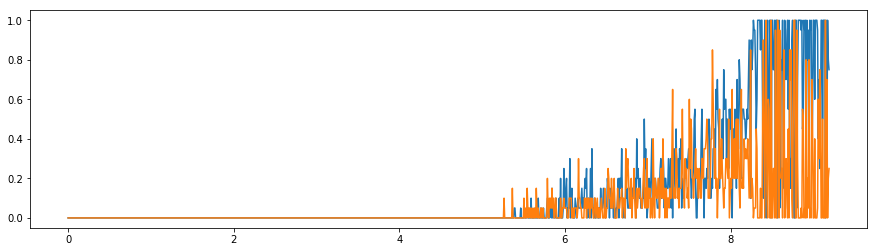

In [50]:
E0 = phi0resdf.energy.iloc[0]
plt.plot(phi0resdf.energy-E0, phi0resdf.lins/20, color="C0", label=r"exponential growth")
plt.plot(phi0resdf.energy-E0, phi0resdf.logs/20, color="C1", label=r"power law growth")
fig = plt.gcf()
fig.set_figwidth(15)

In [51]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

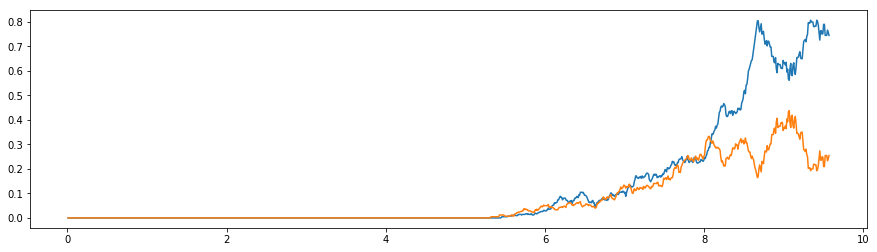

In [79]:
E0 = phi0resdf.energy.iloc[0]
xvals = (phi0resdf.energy-E0).values
yvals = moving_average((phi0resdf.lins/20).values, 21)
plt.plot(xvals[10:-10], yvals, color="C0", label=r"exponential growth")
yvals = moving_average((phi0resdf.logs/20).values, 21)
plt.plot(xvals[10:-10], yvals, color="C1", label=r"power law growth")
fig = plt.gcf()
fig.set_figwidth(15)

In [81]:
def MB_dimension(ic):
    """Estimate the Minkowski–Bouligand dimension by box counting
    
    Parameters:
    -----------
    ic : tuple of tuples of floats
        initial conditions for the system
        example: ((0.1, 0.1), (0.0, 0.0))

    Returns:
    --------
    float The estimated box counting dimension
    """
    import numpy as np
    import multipendulum as mp
    from scipy.optimize import curve_fit
    
    def linear(x, a, b):
        return a*x + b
    
    def count_boxes(pend, nside):
        cols = list(pend.q) + list(pend.p)

        boxids = []
        for col in cols:
            minval = pend.timedf[col].min()
            maxval = pend.timedf[col].max()
            delta = maxval - minval
            spacing = delta/nside
            boxids.append(((pend.timedf[col]-minval)//spacing).astype(int))
        N = len(set(zip(*boxids)))
    
        return np.log(N)/np.log(1/spacing)
        
    pend = mp.run_mp(ic, tmax=1000, nsteps=100000, eigenmodes=True)
    nsides = np.linspace(5, 75, 25).astype(int)
    dim = np.array([count_boxes(pend, nside) for nside in nsides])
    minval = pend.timedf[pend.q[0]].min()
    maxval = pend.timedf[pend.q[0]].max()
    delta = maxval - minval

    xdata = delta/nsides[dim<10]
    ydata = dim[dim<10]
    
    popt, pcov = curve_fit(linear, xdata, ydata)
    return popt[1]

In [83]:
phi0mb = lbv.map_async(MB_dimension, phi0iclist)
phi0mb.wait_interactive()

1600/1600 tasks finished after 3107 s
done


In [ ]:
result1600_phi1_short = lbv.map_async(shortwrapper, phi1iclist)

In [ ]:
result1600_phi1_short.wait_interactive()

In [56]:
phi1resdf = pd.DataFrame(result1600_phi1_short.r)
phi1resdf.to_pickle("phi1-1600-20.pkl")

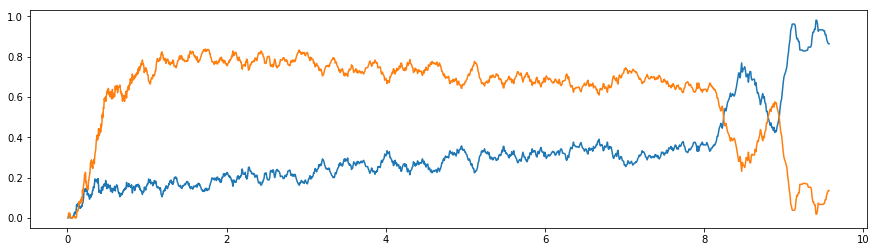

In [78]:
E0 = phi1resdf.energy.iloc[0]
xvals = (phi1resdf.energy).values-E0
yvals = moving_average((phi1resdf.lins/20).values, 21)
plt.plot(xvals[10:-10], yvals, color="C0", label=r"exponential growth")
yvals = moving_average((phi1resdf.logs/20).values, 21)
plt.plot(xvals[10:-10], yvals, color="C1", label=r"power law growth")
fig = plt.gcf()
fig.set_figwidth(15)

In [84]:
phi1mb = lbv.map_async(MB_dimension, phi1iclist)
phi1mb.wait_interactive()

1600/1600 tasks finished after 2652 s
done


In [72]:
pend = mp.MultiPendulum(2)

def calc_energy(ic):
    pend.set_initial_conditions(*ic, eigenmodes=True)
    return pend.efuncs['E'](*pend.y0) - emax_theta1

In [74]:
phi0energies = [calc_energy(ic) for ic in phi0iclist]

In [75]:
phi1energies = [calc_energy(ic) for ic in phi1iclist]

In [76]:
phi1resdf['energy'] = phi1energies

In [77]:
phi0resdf['energy'] = phi0energies

In [86]:
phi1resdf['MBdim'] = phi1mb.r
phi0resdf['MBdim'] = phi0mb.r

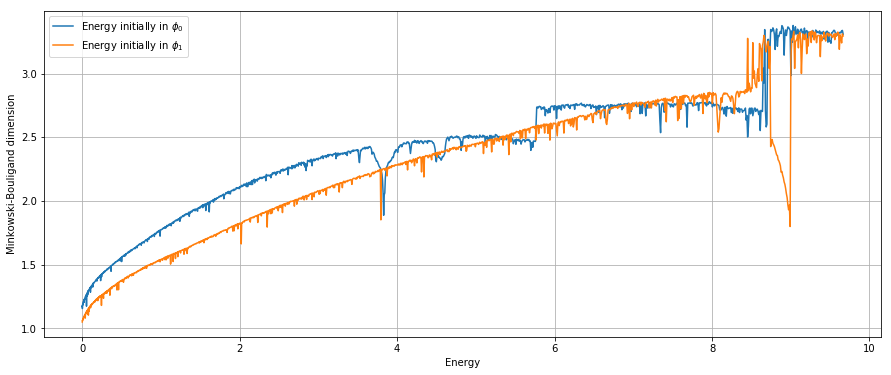

In [87]:
E0 = phi0resdf.energy.iloc[0]
plt.plot(phi0resdf.energy-E0, phi0resdf.MBdim, color="C0", label=r"Energy initially in $\phi_0$")
plt.plot(phi1resdf.energy-E0, phi1resdf.MBdim, color="C1", label=r"Energy initially in $\phi_1$")
fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(6)
plt.legend(loc="upper left", bbox_to_anchor=(0,1))
plt.ylabel("Minkowski-Bouligand dimension")
plt.xlabel("Energy")
plt.grid()

In [88]:
phi1resdf.to_pickle("phi1-1600-20-MB.pkl")
phi0resdf.to_pickle("phi0-1600-20-MB.pkl")